In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.cluster.hierarchy import dendrogram
import pandas as pd

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/home/consulting/Jupyter/smnoh/font/NanumGothic.ttf").get_name()
rc('font', family=font_name)

### 그래프 생성

In [3]:
# connect PostgreSQL
def query_agens(query):
    import psycopg2 as pg2
    from psycopg2 import Error
    from datetime import datetime
    
    start_tm = datetime.now()
    conn = pg2.connect(database="kg_news",user="consulting", host="192.168.0.68", port="15432")
    cur = conn.cursor()

    path_query = "set graph_path = realestate_news_v3;"
    cur.execute(path_query)
    cur.execute(query)
    result = cur.fetchall()
    
    cur.close()
    conn.close()
    
    end_tm = datetime.now()
    print('START: ', str(start_tm))
    print('END: ', str(end_tm))
    print('ELAP: ', str(end_tm - start_tm))
    
    return result

In [4]:
query = """match (s:noun)-[p:predicate]->(o:noun) return s.word, p.verb, o.word"""
result = query_agens(query)
data = pd.DataFrame(result, columns=['subject', 'predicate', 'object'])
#data = data.loc[:50, :]
data

START:  2021-01-08 10:27:06.153347
END:  2021-01-08 10:27:06.171996
ELAP:  0:00:00.018649


,subject,predicate,object
0,정부,발표하다,임대주택 공급
1,정부,위하다,전세시장안정
2,정부,계획이다,전세 대책 발표
3,정부,진행하다,관계부처간 협의
4,정부,옳다,대응방안 마련
...,...,...,...
964,공공임대,필수적이다,지속성
965,공공임대,필수적이다,사업성
966,공공임대,줄여야한다,정부역할
967,공공임대,지적하다,공급대책


#### 방향성 없는 그래프

In [5]:
# 방향성 없는 graph 생성
G = nx.Graph()

# n1, n2 고유값 node 생성
node = list(data['subject'].append(data['object']))
node = list(set(node)) # 중복제거
G.add_nodes_from(node)

for i in data.index:
    G.add_edges_from([(data.subject[i], data.object[i], {'verb':data.predicate[i]})])

In [6]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 920\nNumber of edges: 886\nAverage degree:   1.9261'

#### 방향성 있는 그래프(사용하진 않음)

In [ ]:
#방향성 있는 그래프 생성
G1 = nx.DiGraph()

# n1, n2 고유값 node 생성
node = list(data['subject'].append(data['object']))
node = list(set(node)) # 중복제거
G1.add_nodes_from(node)

for i in data.index:
    G1.add_edges_from([(data.subject[i], data.object[i], {'verb':data.predicate[i]})])

In [ ]:
#엣지라벨 보이게 하기
plt.figure(figsize=(16, 8))
pos=nx.spring_layout(G1) # layout 종류 바꾸면 그림이 달라짐 'kamada_kawai_layout' 아니면 'spring_layout'
nx.draw(G1, pos, with_labels = True, font_weigth = "bold", font_family=font_name, edge_color='gray')

labels = nx.get_edge_attributes(G1,'verb')
nx.draw_networkx_edge_labels(G1, pos, edge_labels = labels, font_family=font_name);
plt.show()

### Hierarchical Graph Clustering using Node Pair Sampling
https://arxiv.org/pdf/1806.01664.pdf

In [14]:
def HC(G):
    n = G.number_of_nodes()
    g = G.copy()

    # 노드를 정수로 변환
    if set(g.nodes()) != set(range(n)):
        g = nx.convert_node_labels_to_integers(g, label_attribute='noun')
        f = g.copy()  # old label을 꺼내기 위해 저장
    # 노드의 weight 초기화 및 계산
    w = {u: 0 for u in range(n)}
    wtot = 0
    for (u,v) in g.edges():
        if 'weight' not in g[u][v]:
            g[u][v]['weight'] = 1
        weight = g[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += weight
        if u != v:
            wtot += weight

    # cluster 리스트 초기화
    s = {u: 1 for u in range(n)}
    
    cc = [] # connected components
    D = []  # dendrogram 리스트
    #print(g.nodes())

    # cluster 계산
    u = n
    while n > 0:
        # nearest-neighbor chain
        chain = [list(g.nodes())[0]]
        while chain != []:
            a = chain.pop()
            dmin = np.inf
            b = -1
            # neares-neighbor를 찾는 부분
            for v in g.neighbors(a): 
                if v != a:
                    d = w[v] * w[a] / float(g[a][v]['weight']) / float(wtot)
                    if d < dmin:
                        b = v
                        dmin = d
                    elif d == dmin:
                        b = min(b,v) # a와 가장 가까운 b 탐색 
            d = dmin
            if chain != []:
                c = chain.pop()
                if b == c:
                    # dendrogram 리스트에 값 대임
                    D.append([a,b,d,s[a] + s[b]])
                    # 변경된 cluster 기준으로 네트워크 업데이트
                    g.add_node(u)
                    neighbors_a = list(g.neighbors(a))
                    neighbors_b = list(g.neighbors(b))
                    for v in neighbors_a:
                        g.add_edge(u,v,weight = g[a][v]['weight'])
                    for v in neighbors_b:
                        if g.has_edge(u,v):
                            g[u][v]['weight'] += g[b][v]['weight']
                        else:
                            g.add_edge(u,v,weight = g[b][v]['weight'])
                    g.remove_node(a)
                    g.remove_node(b)
                    n -= 1
                    # weight와 size 업데이트
                    w[u] = w.pop(a) + w.pop(b)
                    s[u] = s.pop(a) + s.pop(b)
                    # node index보다 높은 값으로 cluster index 지정
                    u += 1
                else:
                    chain.append(c)
                    chain.append(a)
                    chain.append(b)
            elif b >= 0:
                chain.append(a)
                chain.append(b)   
            else:
                # connected componet 제거
                cc.append((a,s[a]))
                g.remove_node(a)
                w.pop(a)
                s.pop(a)
                n -= 1
    # connected component를 덴드로그램에 저장
    
    a,s = cc.pop()
    
    for b,t in cc:
        s += t
        D.append([a,b,np.inf,s])
        a = u
        u += 1
        
    return reorder_dendrogram(np.array(D))

In [11]:
# dendrogram 입력 형태에 맞게 변환
def reorder_dendrogram(D):
    n = np.shape(D)[0] + 1
    order = np.zeros((2,n - 1),float)
    order[0] = range(n - 1)
    order[1] = np.array(D)[:,2]
    index = np.lexsort(order)
    nindex = {i:i for i in range(n)}
    nindex.update({n + index[t]:n + t for t in range(n - 1)})
    return np.array([[nindex[int(D[t][0])],nindex[int(D[t][1])],D[t][2],D[t][3]] for t in range(n - 1)])[index,:]

In [12]:
# dendrogram 형태의 결과값에서 원하는 클러스터 갯수만큼 클러스터 추출
def select_clustering(D, k):
    n = np.shape(D)[0] + 1
    k = min(k,n - 1)
    cluster = {i:[i] for i in range(n)}
    for t in range(n):
        if len(cluster.values())>k:
            cluster[n + t] = cluster.pop(int(D[t][0])) + cluster.pop(int(D[t][1]))
            
    cluster_array=sorted(cluster.values(), key = len, reverse = True)
    
    return cluster_array

#### karate club network 예시

In [6]:
test_karate=np.loadtxt('/home/consulting/Jupyter/adrianj/Data/Network/karate_network.txt')
karate_bin=test_karate[:34,:]
karate_val=test_karate[34:,:]

G_karate = nx.Graph(karate_bin)

In [15]:
z= HC(G_karate)

In [17]:
len(z)

33

In [18]:
select_clustering(z,4)

[[21, 17, 1, 19, 12, 3, 7, 11, 0, 9, 2, 13],
 [32, 14, 15, 18, 22, 33, 20, 30, 8],
 [23, 27, 29, 26, 31, 28, 25, 24],
 [16, 5, 6, 10, 4]]

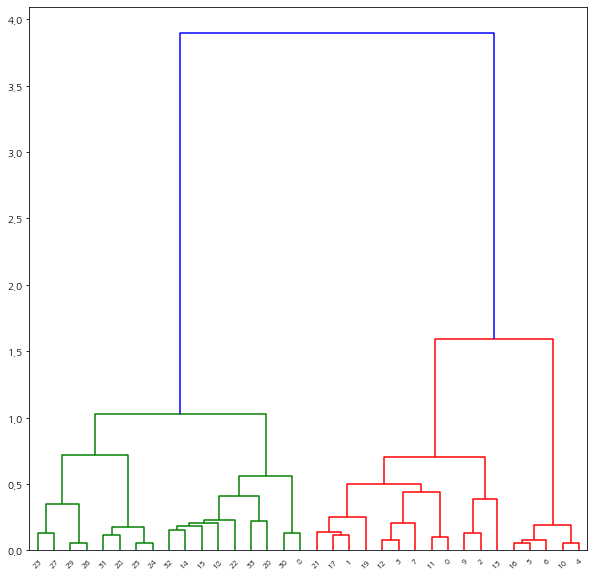

In [19]:
plt.figure(figsize=(10, 10))
dendrogram(z)
plt.show()

#### 뉴스SPO데이터 적용

##### 클러스터링 수행
- 1.1에서 생성한 G 사용

In [ ]:
z,g = HC(G) #노드명이 프린트됨

n = 5
c = select_clustering(z,n) #max 군집 개수: np.shape(z)[0] -> 이건 항상 노드개수-1 ??? 
size = [len(i) for i in c]

# 첫번째 군집의 사이즈만 너무 큼 => Giant Component 대상으로 클러스터링 재수행
print('#of clusers / size of each cluster')
for k in range(1,10):
    c = select_clustering(z,k)
    print(k, ' / ', [len(i) for i in c])

거리가 infinite인 노드들로 인해 덴드로그램 그리기 불가능

In [ ]:
plt.figure(figsize=(10, 10))
dendrogram(z)
plt.show()

#### Giant Component 생성

Giant cluster에 속한 SPO 추출

In [10]:
gc_nodes = list(sorted(nx.connected_components(G), key=len, reverse=True)[0])

#주어
query1 = "match (s:noun)-[r:predicate]->(o:noun) where s.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result1 = query_agens(query1)
data1 = pd.DataFrame(result1, columns=['subject', 'predicate', 'object'])

#목적어
query2 = "match (s:noun)-[r:predicate]->(o:noun) where o.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result2 = query_agens(query2)
data2 = pd.DataFrame(result2, columns=['subject', 'predicate', 'object'])

gc_df = pd.concat([data1, data2], ignore_index=True)
gc_df = gc_df.drop_duplicates()

START:  2021-01-08 10:27:38.940293
END:  2021-01-08 10:27:38.964034
ELAP:  0:00:00.023741
START:  2021-01-08 10:27:38.965977
END:  2021-01-08 10:27:38.988909
ELAP:  0:00:00.022932


그래프 생성

In [117]:
GC = nx.Graph()

#노드추가
nouns = list(gc_df.subject) + list(gc_df.object)
node = set(nouns)
GC.add_nodes_from(node)

#엣지추가
for i in gc_df.index:
    GC.add_edges_from([(gc_df.subject[i], gc_df.object[i], {'verb':gc_df.predicate[i]})])

In [118]:
print(nx.info(GC))
print(len(sorted(nx.connected_components(GC), key=len, reverse=True)))

Name: 
Type: Graph
Number of nodes: 569
Number of edges: 662
Average degree:   2.3269
1


##### Giant Component  클러스터링 수행

In [119]:
z,g = HC(GC) 

# int로 변환된 라벨과 원래노드 매칭
# nx.convert_node_labels_to_integers의 label_attribute 옵션, nx.get_node_attributes 이용
old_nodes = nx.get_node_attributes(g,'noun')

modularity_list = []

# 최대 modularity를 찾기 위해 cluster 갯수 2~50개까지 계산
for cluster_num in range(1, 51):
    n=cluster_num
    tmp_cluster =select_clustering(z,n)
    #cluster별 keyword 치환
    for i in range(len(tmp_cluster)):
        for j in range(len(tmp_cluster[i])):
            tmp_cluster[i][j] = old_nodes[tmp_cluster[i][j]]
            
    
    modularity_list.append(nx.community.modularity(GC, tmp_cluster))
    
max_m = modularity_list.index(max(modularity_list))+1
print("modularity가 가장 높은 cluster 갯수:", max_m)

#n개의 군집으로 클러스터링
opt_clusters =select_clustering(z,max_m)
#각 군집별 사이즈
size = [len(i) for i in clusters]
print("size of each cluster:",size)

modularity가 가장 높은 cluster 갯수: 20
size of each cluster: [64, 61, 52, 47, 35, 33, 30, 30, 29, 27, 27, 25, 20, 18, 17, 17, 15, 8, 8, 6]


- 군집 수 cutoff using Entropy?? (ranyi disparity)

In [160]:
import math

normal_size = []
total = sum(size)
for i in size:
    normal_size.append(i/total)

w=[]
for i in normal_size:
    w.append(i*math.log(i))

math.exp(-sum(w))  # 17개 이하인 군집은 버리기?? (정확한 해석법은 잘모름)

17.039205945479274

In [154]:
clusters = [] #원래의 명사로 변환하여 리스트에 담기
for i in range(len(opt_clusters)):  #opt_clusters : integer 노드로 구성된 클러스터들
    nouns = []
    for j in opt_clusters[i]:
        nouns.append(old_nodes[j])  #old_nodes: 원래노드명/정수변환 노드 매칭시킨 딕셔너리
    clusters.append(nouns)

In [155]:
clusters

[['국민들 신음',
  '부작용',
  '다른 곳',
  '비난여론',
  '3+3년 개정안',
  '도입',
  '추가대책',
  '무조건',
  '홍남기 부총리',
  '목적지',
  '오류',
  '27.40%',
  '주택담보대출',
  '주택 및 지역 개발부',
  '신설',
  '부동산시장 안정',
  '자체수급',
  '정부',
  '취약계층 수급',
  '공급 확대',
  '대북정책',
  '영향 분석',
  '원희룡 제주지사',
  '인구 감소로 따른 가구 분화',
  '대응방안 마련',
  '전세시장 안정',
  '임대인 보호',
  '투기세력',
  '실수요자 보호',
  '서민불안',
  '부동산매매 수익',
  '시장 존중 대책',
  '대책 마련',
  '대출 규제',
  '표준임대료 도입',
  '언론',
  '대책의 여지',
  '기존 정책 추진',
  '시장불안정',
  '전세 대책 발표',
  '관계부처간 협의',
  '기존정책 방향성',
  '전월세 대란 대책',
  '전세시장안정',
  '공시지가',
  '주택가격 안정',
  '신규대책 발표',
  '전세난 안정',
  '금리탓',
  '검찰개혁',
  '재건축 규제',
  '저금리 원인',
  '분노',
  '해법',
  '기존정책',
  '응답자 38.8%',
  '실수요자보호',
  '부동산시장안정',
  '의지',
  '투기억제',
  '지분적립형 분양주택',
  '2023년',
  '도심',
  '공급 모델'],
 ['설문조사',
  '수도권 주민',
  '여론조사기관',
  '더불어민주당',
  '후속 대책',
  '3+3 개정안',
  '윤호중 의원',
  '부동산대책',
  '혼란',
  '임대차법',
  '수급불균형',
  '임대료 증액',
  '부동산시장 과열',
  '사회적 시장경제질서',
  '사회적 연대',
  '축조심사',
  '전세기간 연장',
  '연대',
  '7월 31일',
  '세 달',
  '국민 기본권',
  '공급불안',
  '재산권

opt_clusters와 개수 일치하는지 확인

In [122]:
size == [len(i) for i in clusters]

True

엣지리스트로부터 SPO 추출

In [123]:
#전체 그래프의 엣지리스트
edgelist = nx.get_edge_attributes(GC,'verb')

In [124]:
#클러스터별 SPO 추출
spolist = {}
for k in range(len(clusters)):
    nodepair = []
    for i in clusters[k]:
        for j in clusters[k]:
            a = (i,j)
            nodepair.append(a)
    spo = {}
    for i in nodepair:
        try:
            spo[i] = edgelist[i]           
        except KeyError:
            continue
    spolist[k] = spo

In [125]:
#추출된 SPO리스트에서 클러스터별 명사 개수 확인하여 대조
nounlist = []
for i in range(len(spolist)):
    keys = list(spolist[i].keys())
    nouns = []
    for i in keys:
        nouns.append(i[0])
        nouns.append(i[1])
    nouns = set(nouns)
    nounlist.append(nouns)

In [126]:
size1 = [len(nounlist[i]) for i in range(len(nounlist))]
size1 == size

True

In [159]:
spolist[0]

{('부작용', '국민들 신음'): '소급적용되다',
 ('부작용', '다른 곳'): '있다',
 ('부작용', '정부'): '보완하다',
 ('3+3년 개정안', '비난여론'): '나타나다',
 ('3+3년 개정안', '도입'): '파국이다',
 ('추가대책', '홍남기 부총리'): '고민하다',
 ('무조건', '추가대책'): '만들지않다',
 ('오류', '목적지'): '멀어지다',
 ('주택담보대출', '27.40%'): '증가하다',
 ('신설', '주택 및 지역 개발부'): '검토하다',
 ('자체수급', '부동산시장 안정'): '만들어지다',
 ('정부', '3+3년 개정안'): '고려않다',
 ('정부', '추가대책'): '예정하다',
 ('정부', '오류'): '인정하지 않다',
 ('정부', '주택담보대출'): '규제하다',
 ('정부', '주택 및 지역 개발부'): '고려않다',
 ('정부', '부동산시장 안정'): '단호하다',
 ('정부', '원희룡 제주지사'): '비판하다',
 ('정부', '인구 감소로 따른 가구 분화'): '언급하다',
 ('정부', '대응방안 마련'): '옳다',
 ('정부', '전세시장 안정'): '위하다',
 ('정부', '임대인 보호'): '고려해야하다',
 ('정부', '투기세력'): '규제하다',
 ('정부', '실수요자 보호'): '단호하다',
 ('정부', '서민불안'): '알다',
 ('정부', '부동산매매 수익'): '낮출수밖에없다',
 ('정부', '시장 존중 대책'): '마련해야 하다',
 ('정부', '대책 마련'): '고심하다',
 ('정부', '대출 규제'): '시행하다',
 ('정부', '표준임대료 도입'): '불가하다',
 ('정부', '언론'): '반박하다',
 ('정부', '대책의 여지'): '모색하다',
 ('정부', '기존 정책 추진'): '주력하다',
 ('정부', '시장불안정'): '대책 세우다',
 ('정부', '전세 대책 발표'): '계획이다',
 ('정부', '관계부처간

##### 시각화

cluster 0


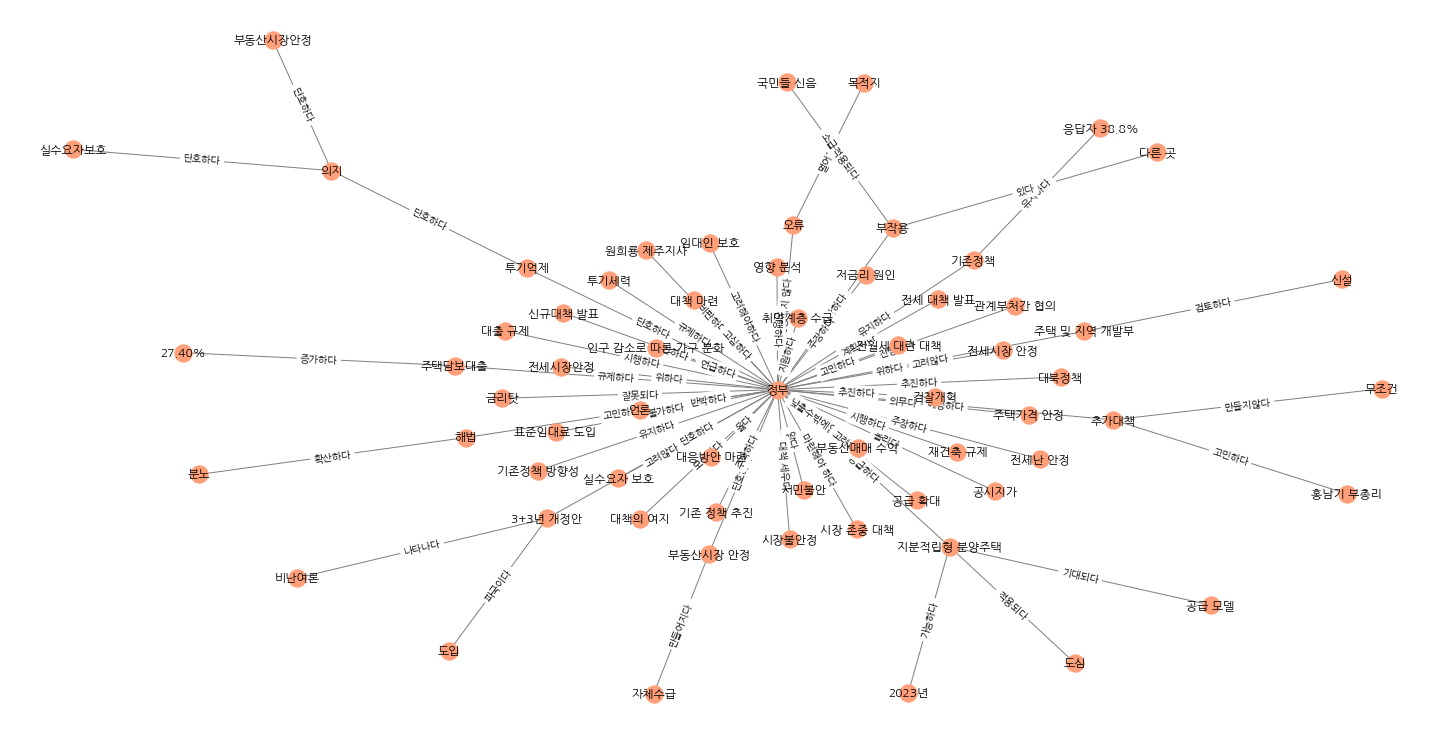

cluster 1


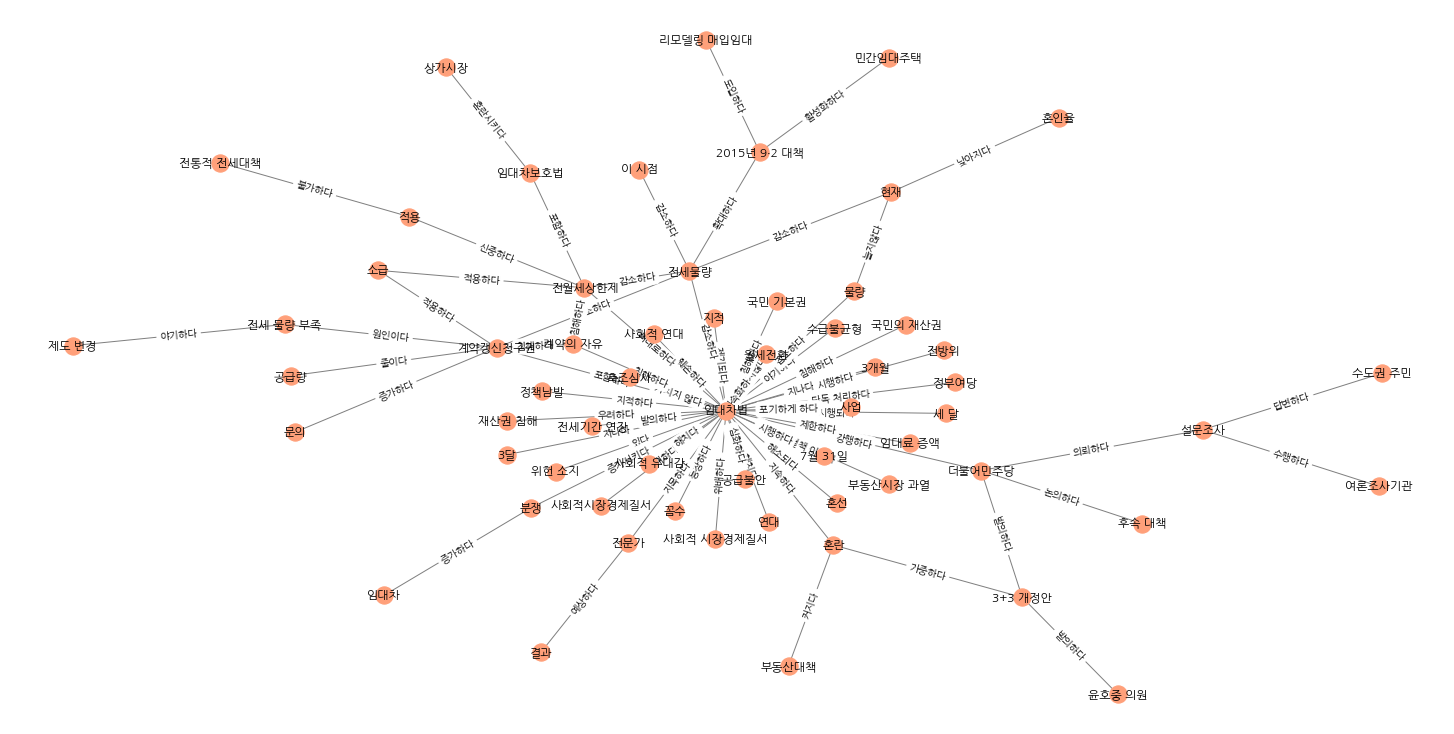

cluster 2


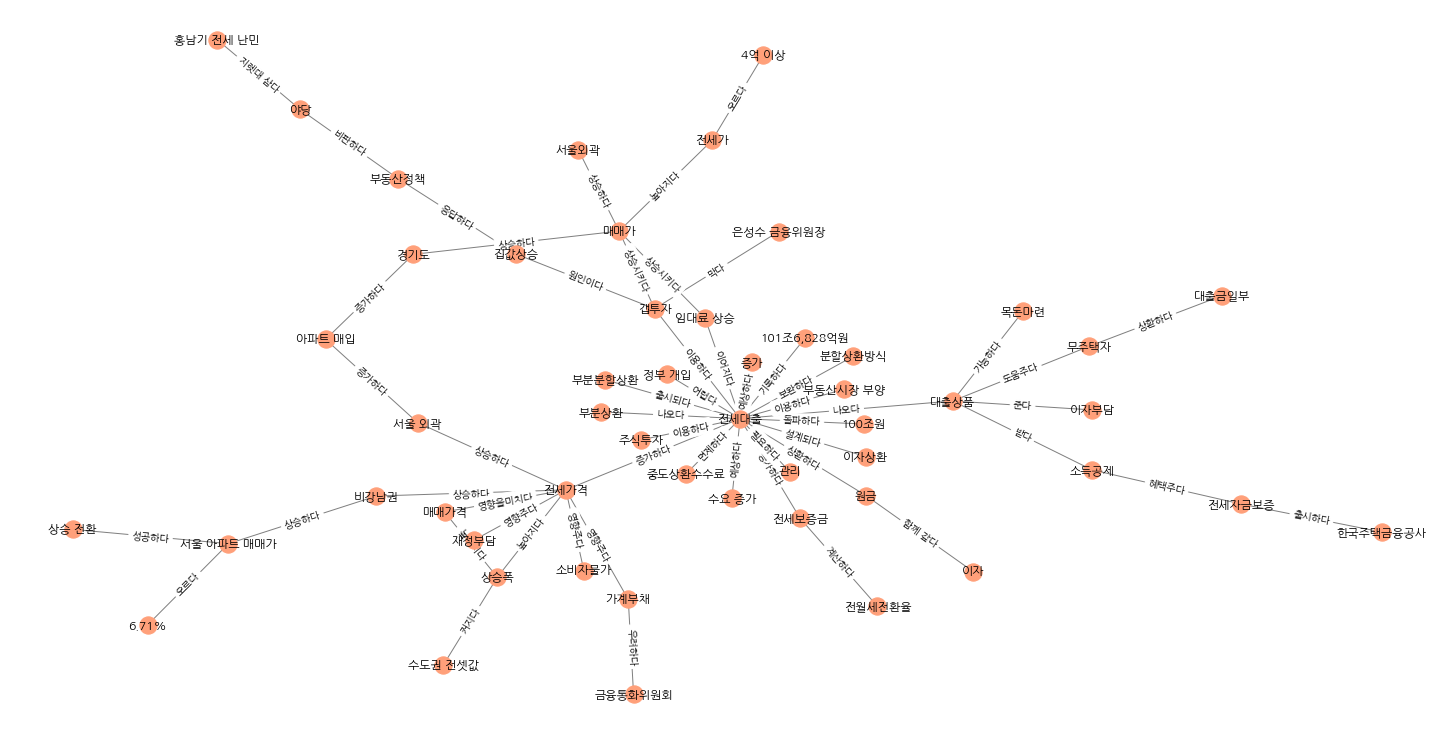

cluster 3


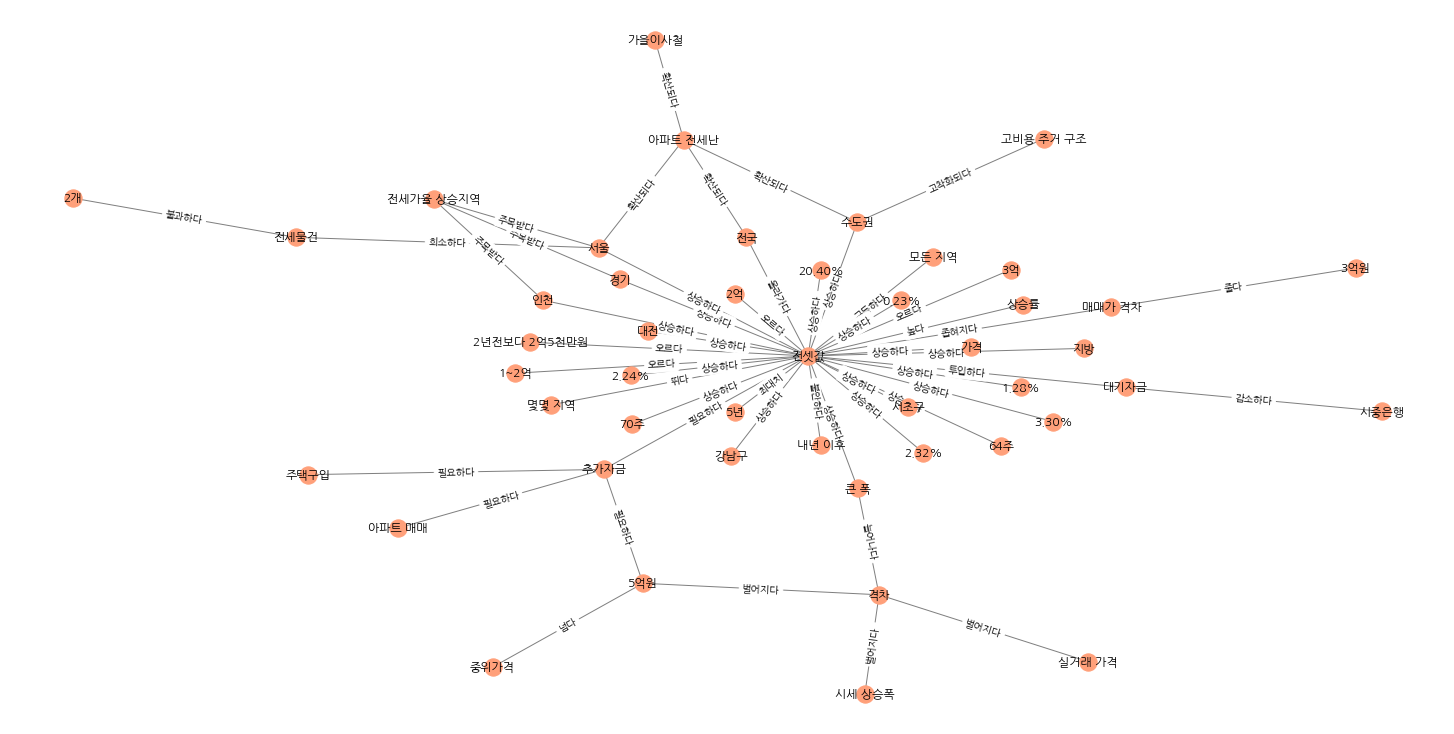

cluster 4


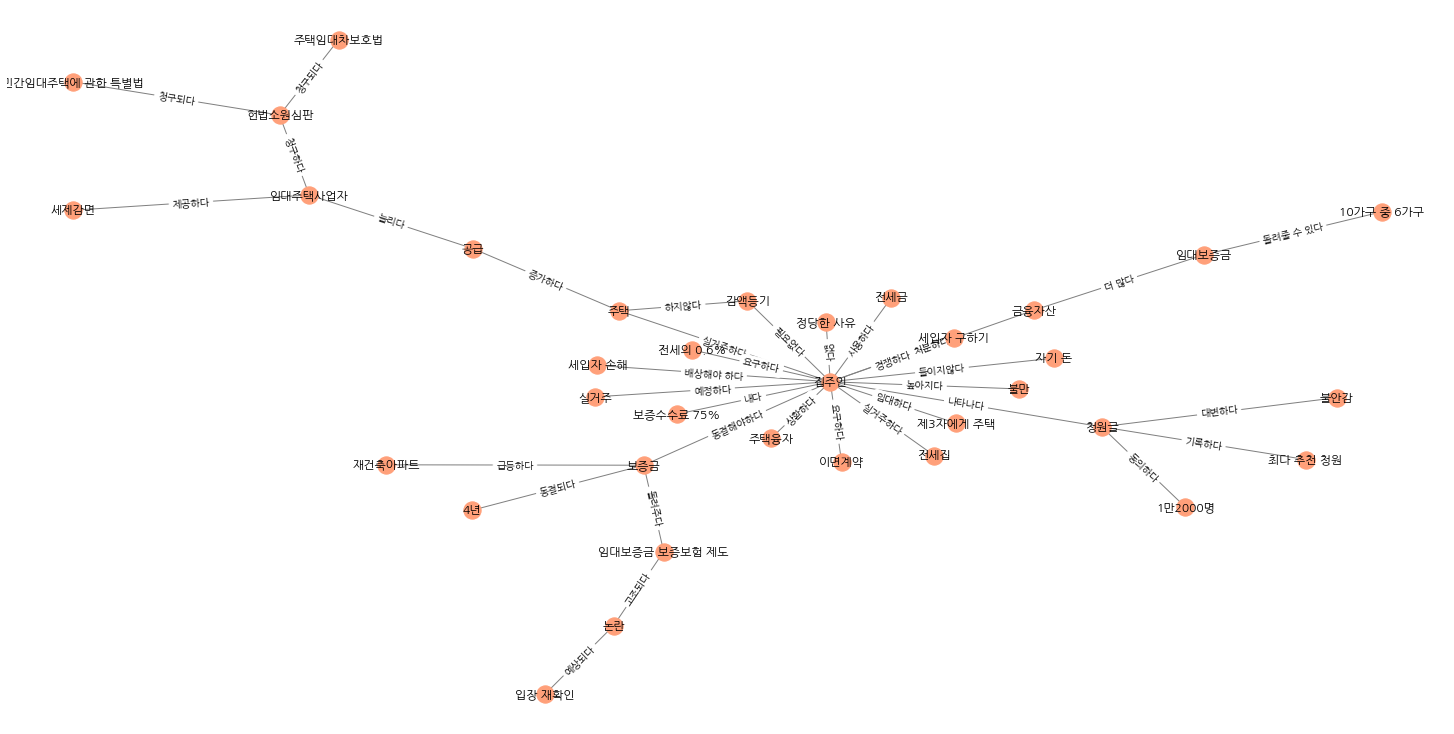

cluster 5


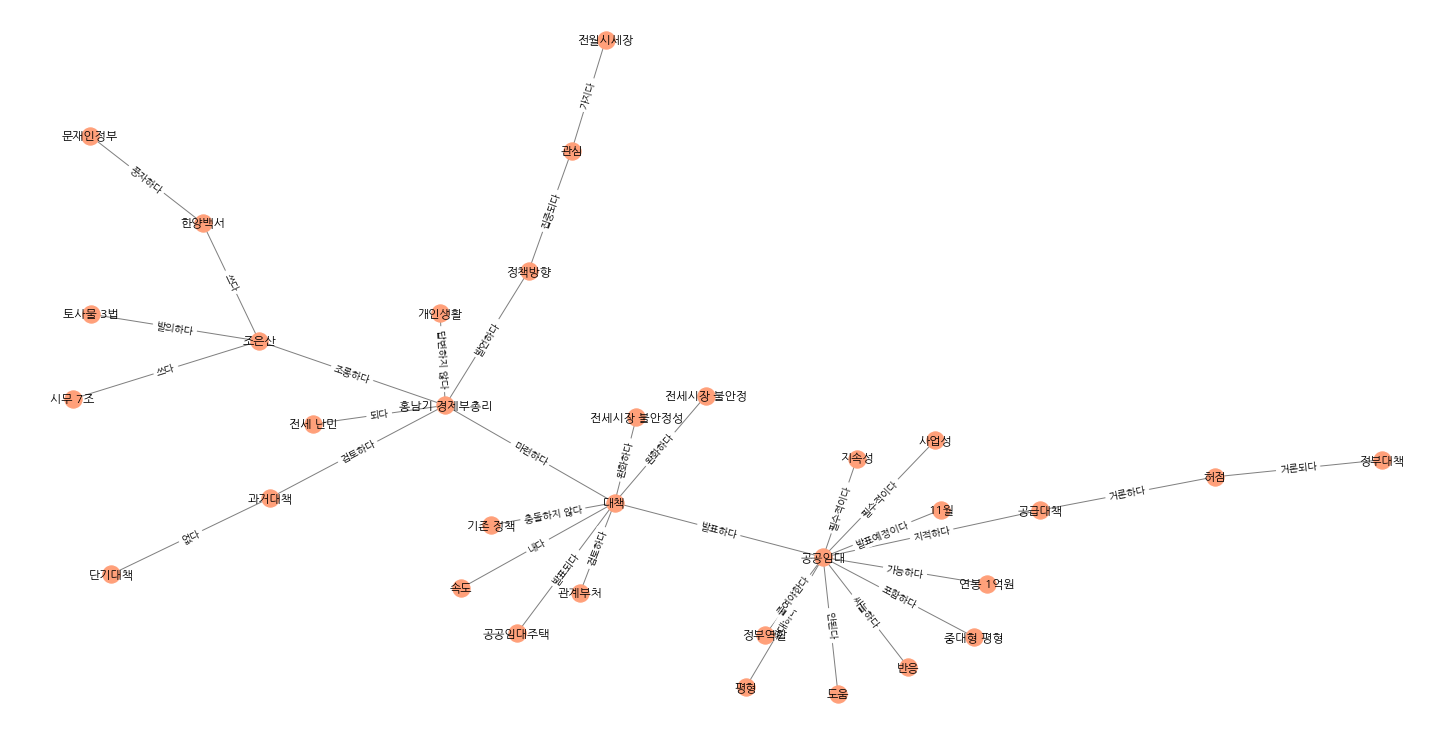

cluster 6


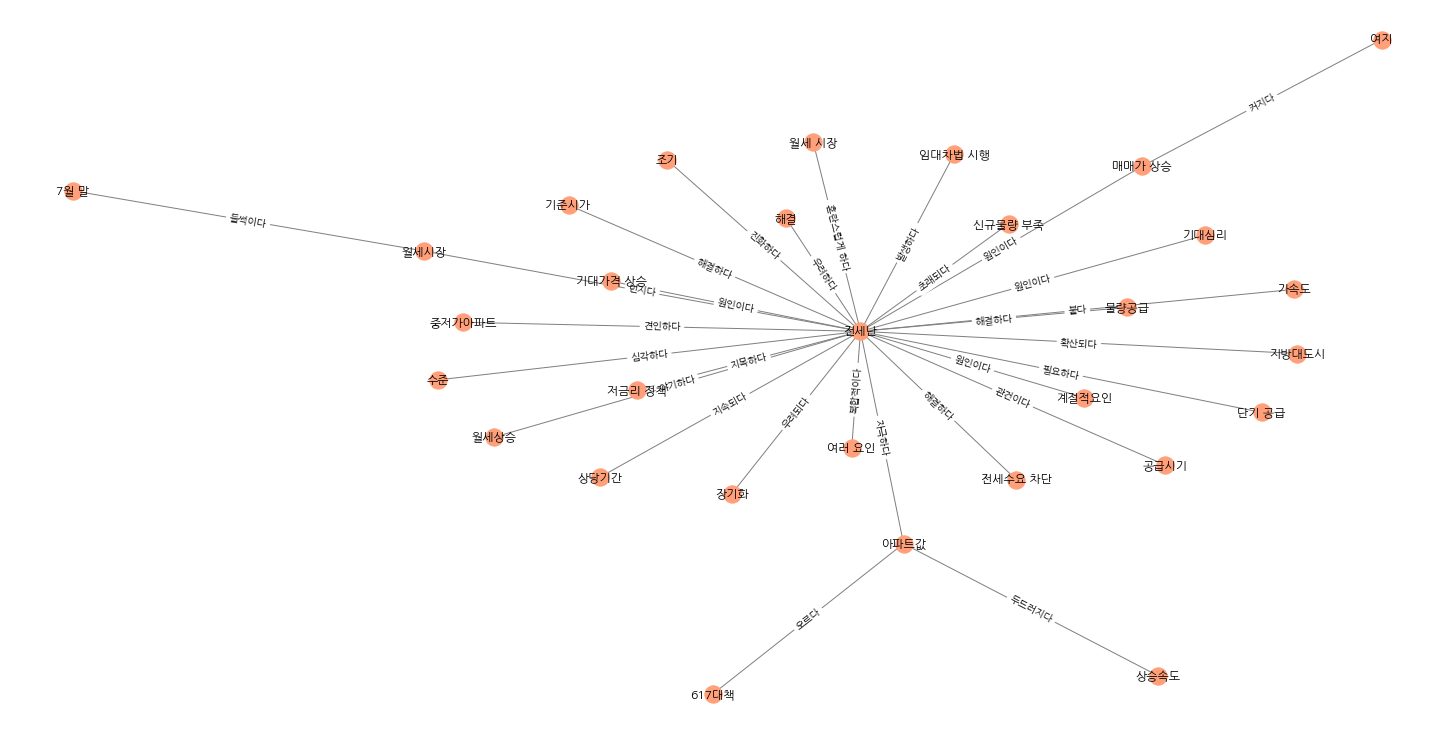

cluster 7


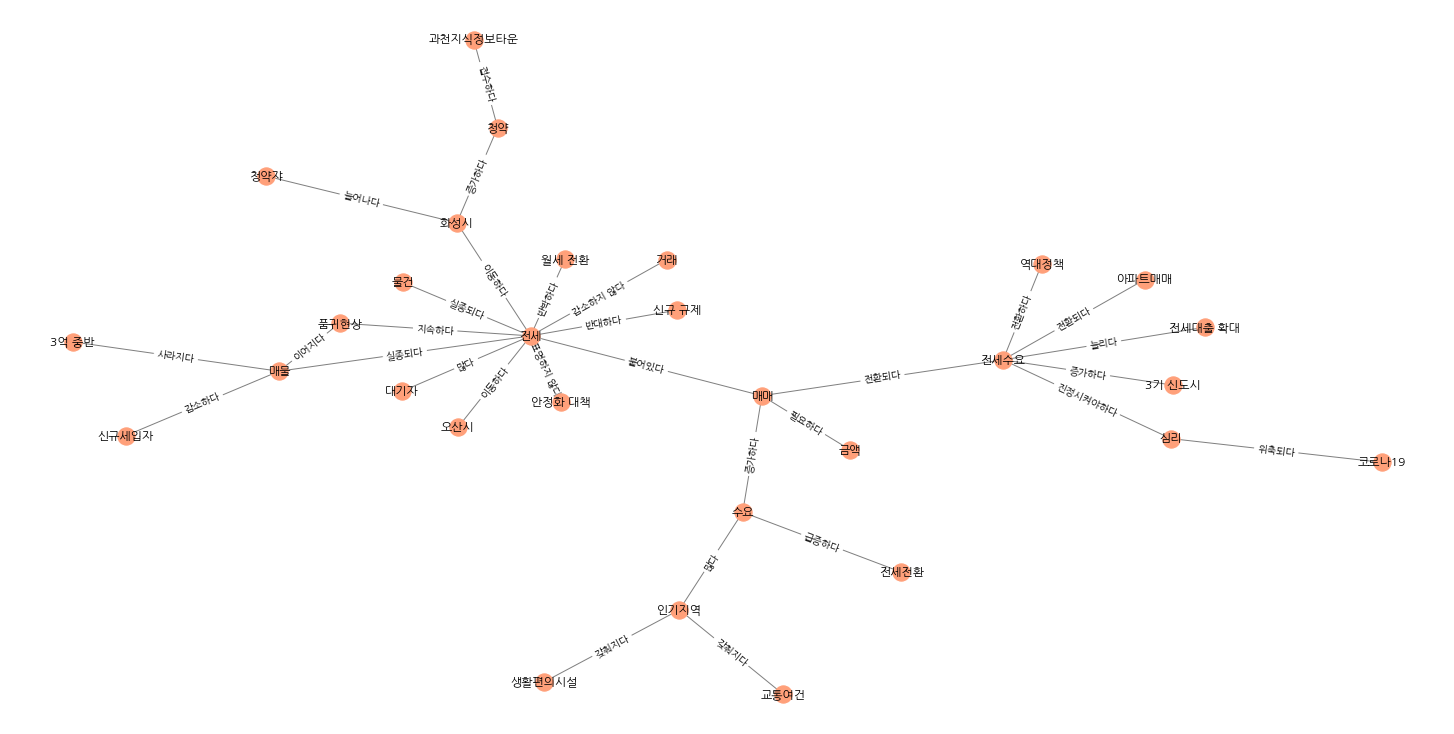

cluster 8


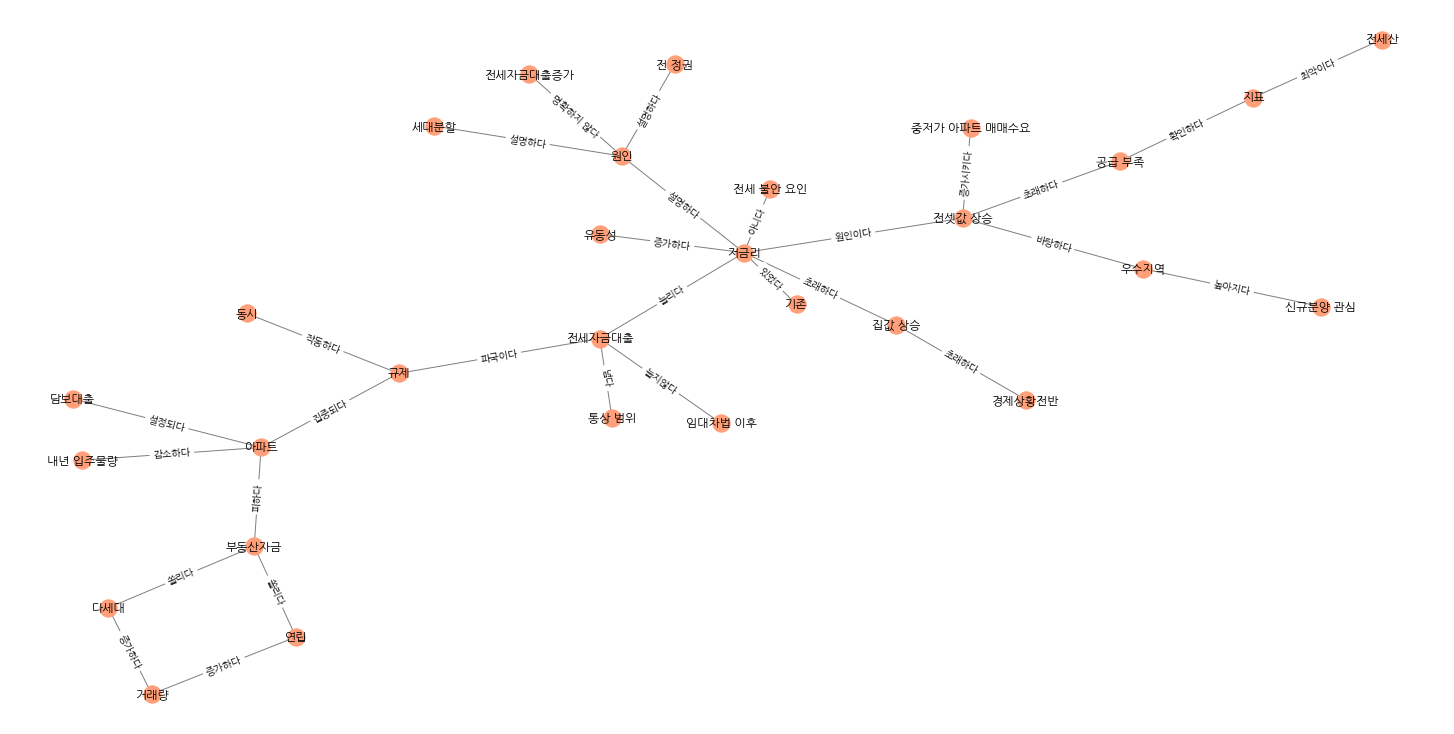

cluster 9


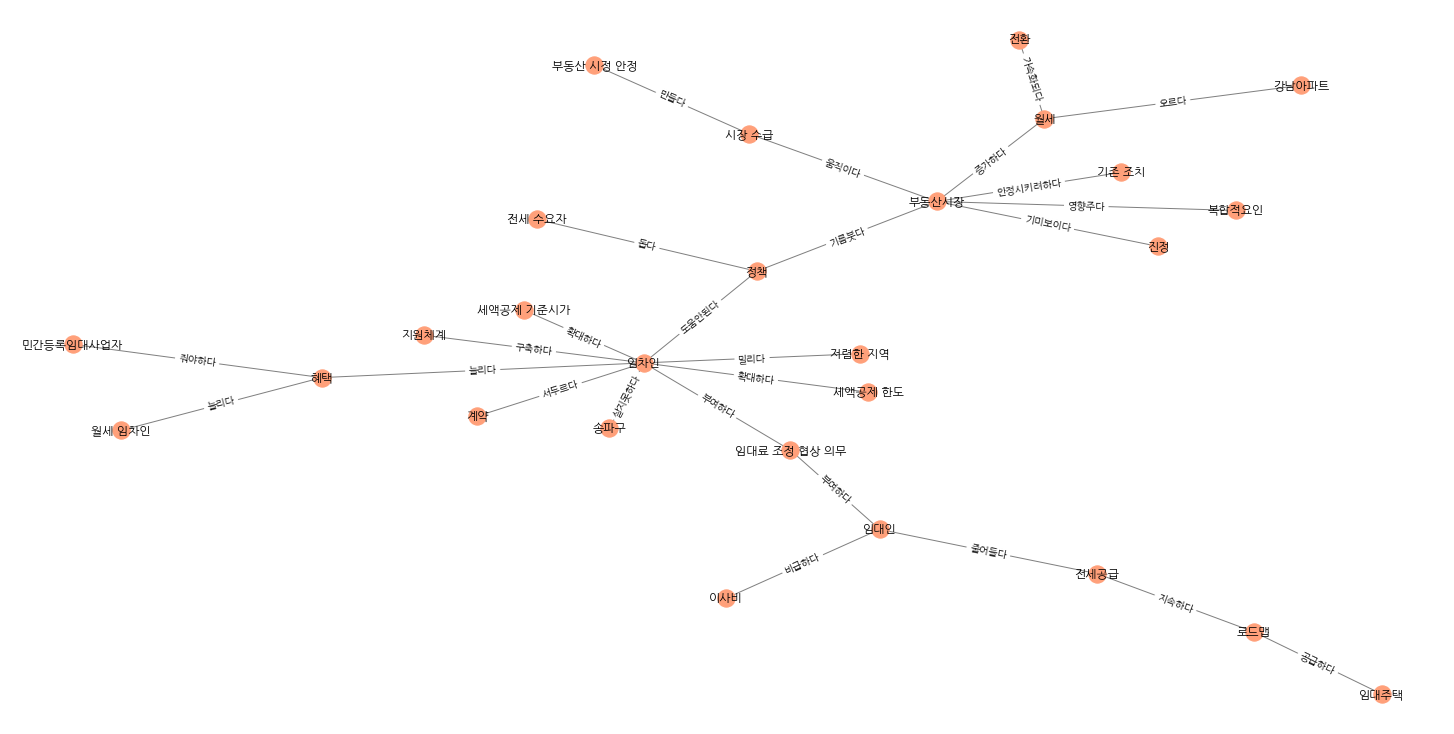

cluster 10


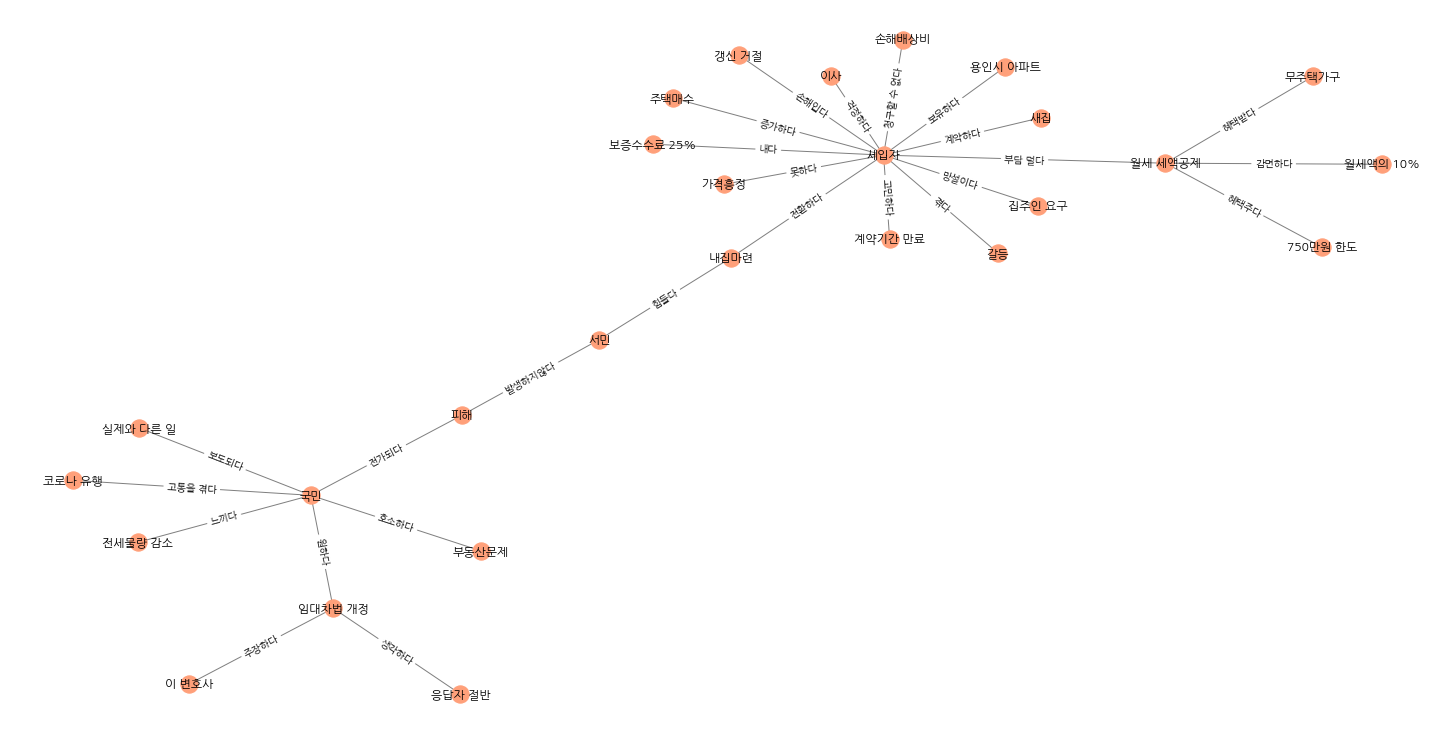

cluster 11


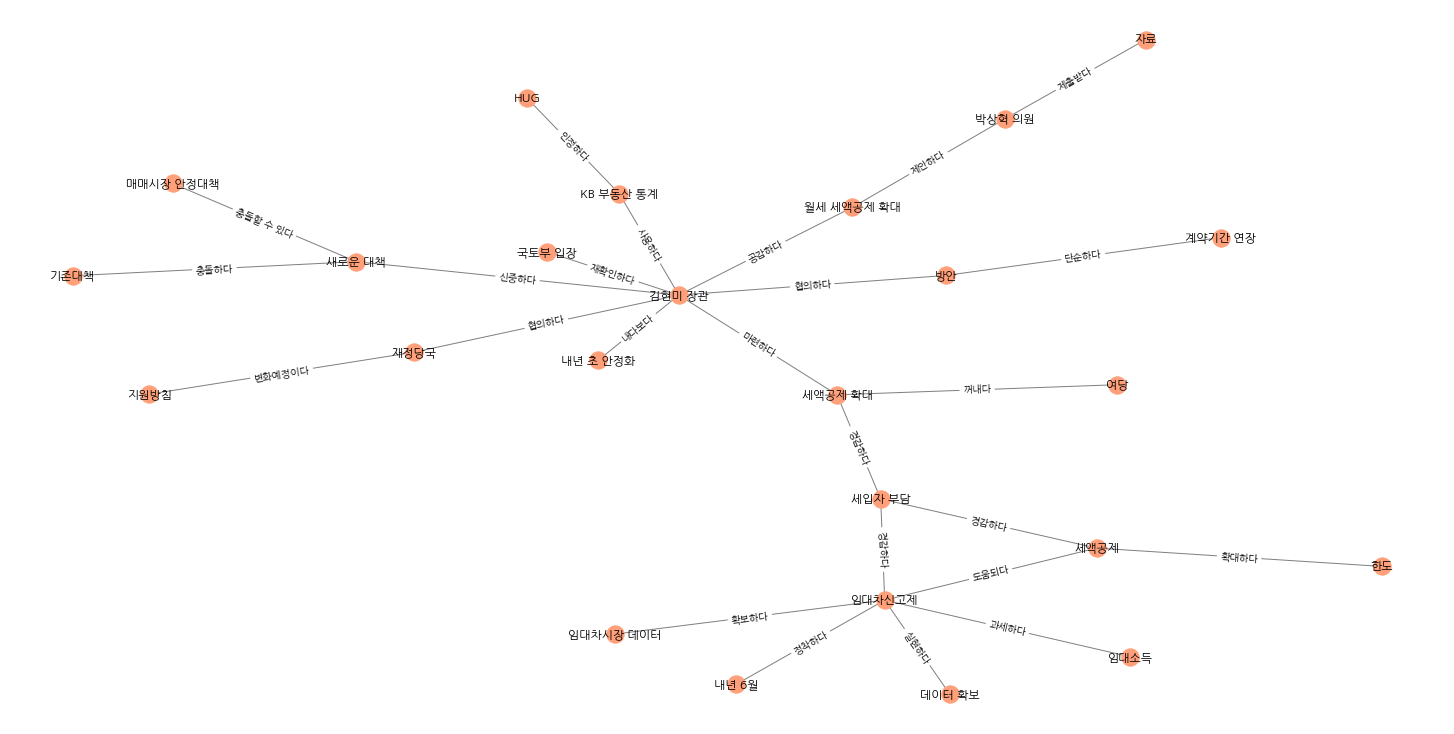

cluster 12


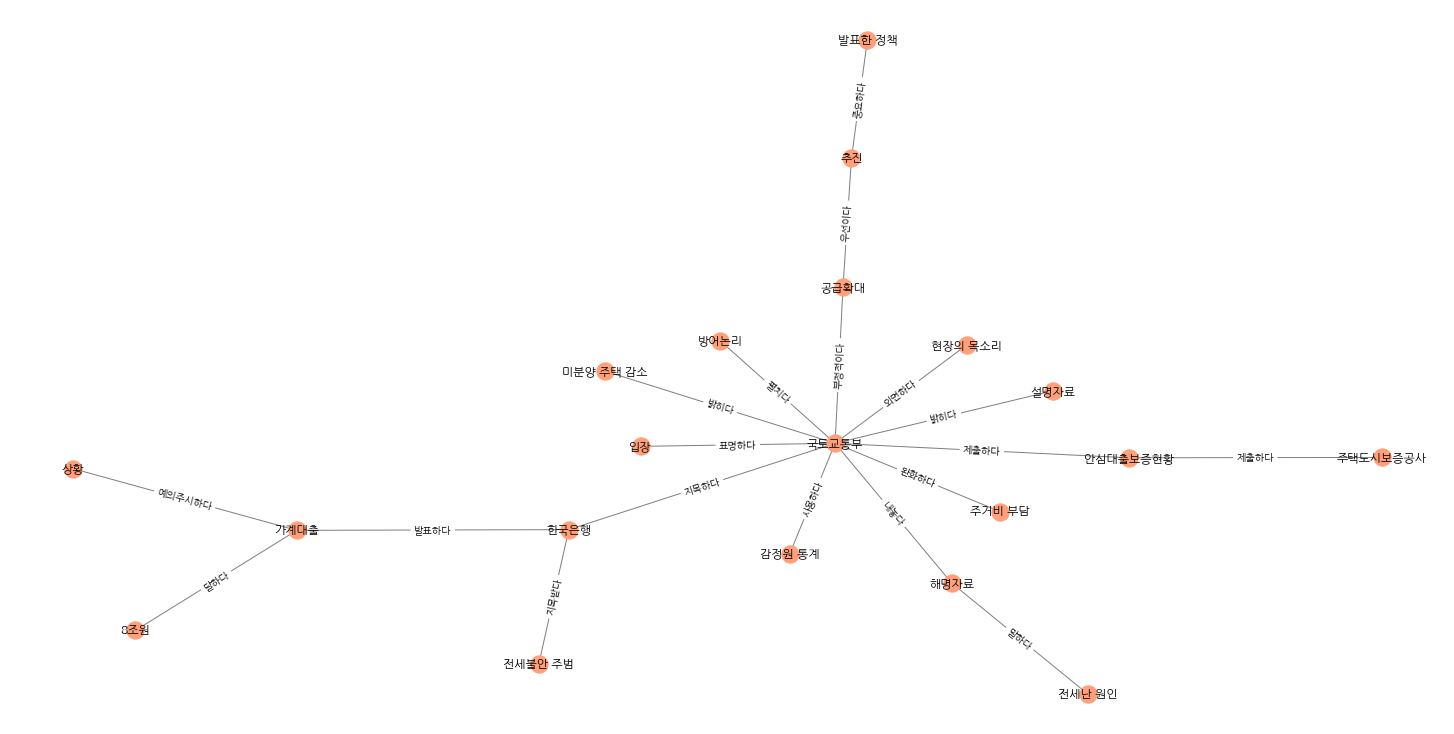

cluster 13


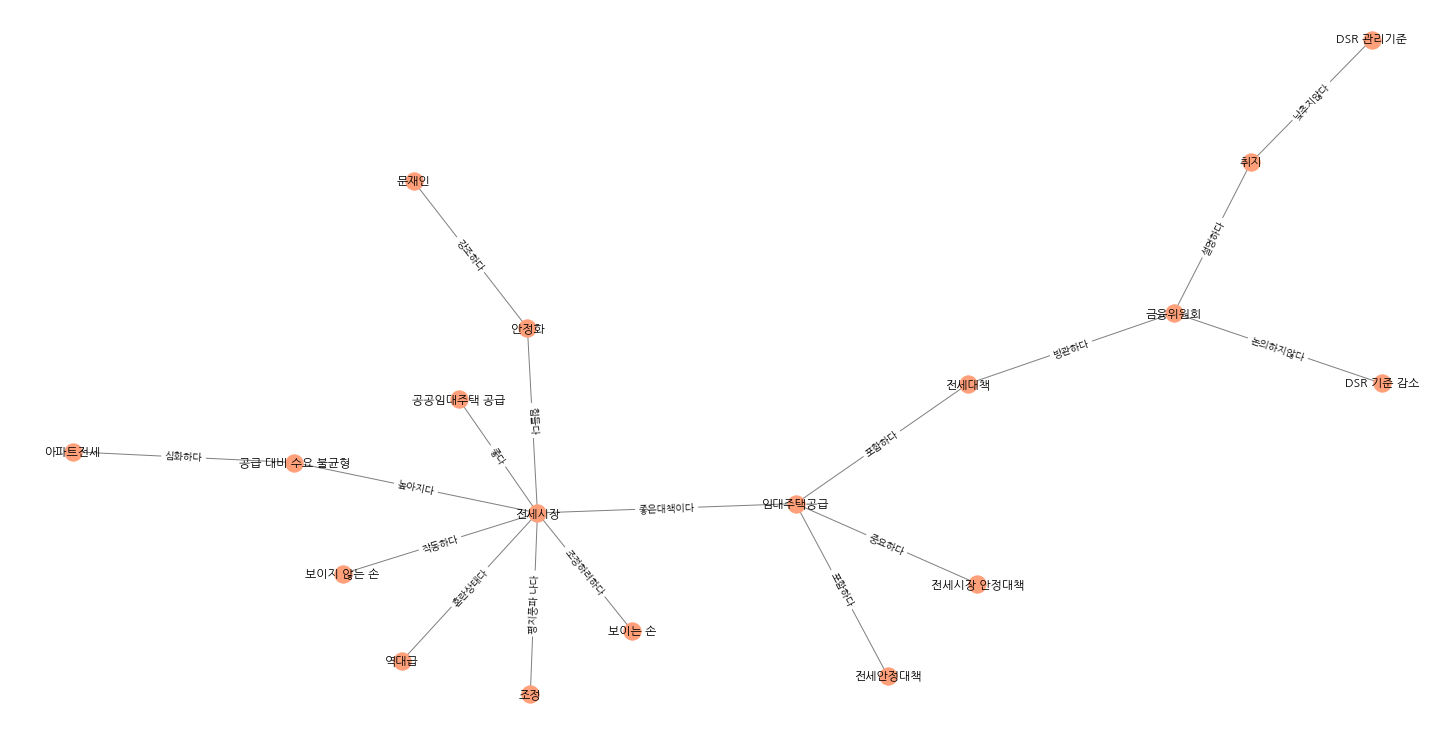

cluster 14


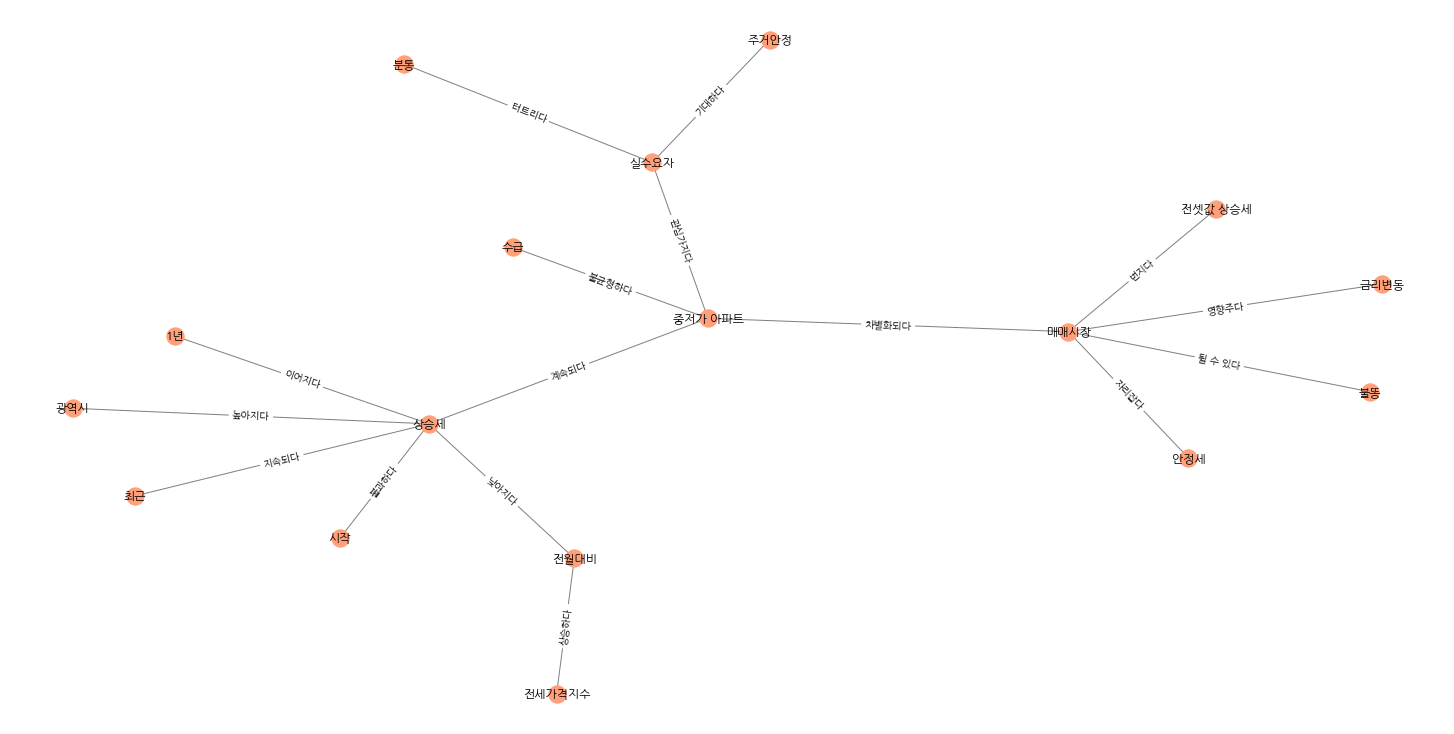

cluster 15


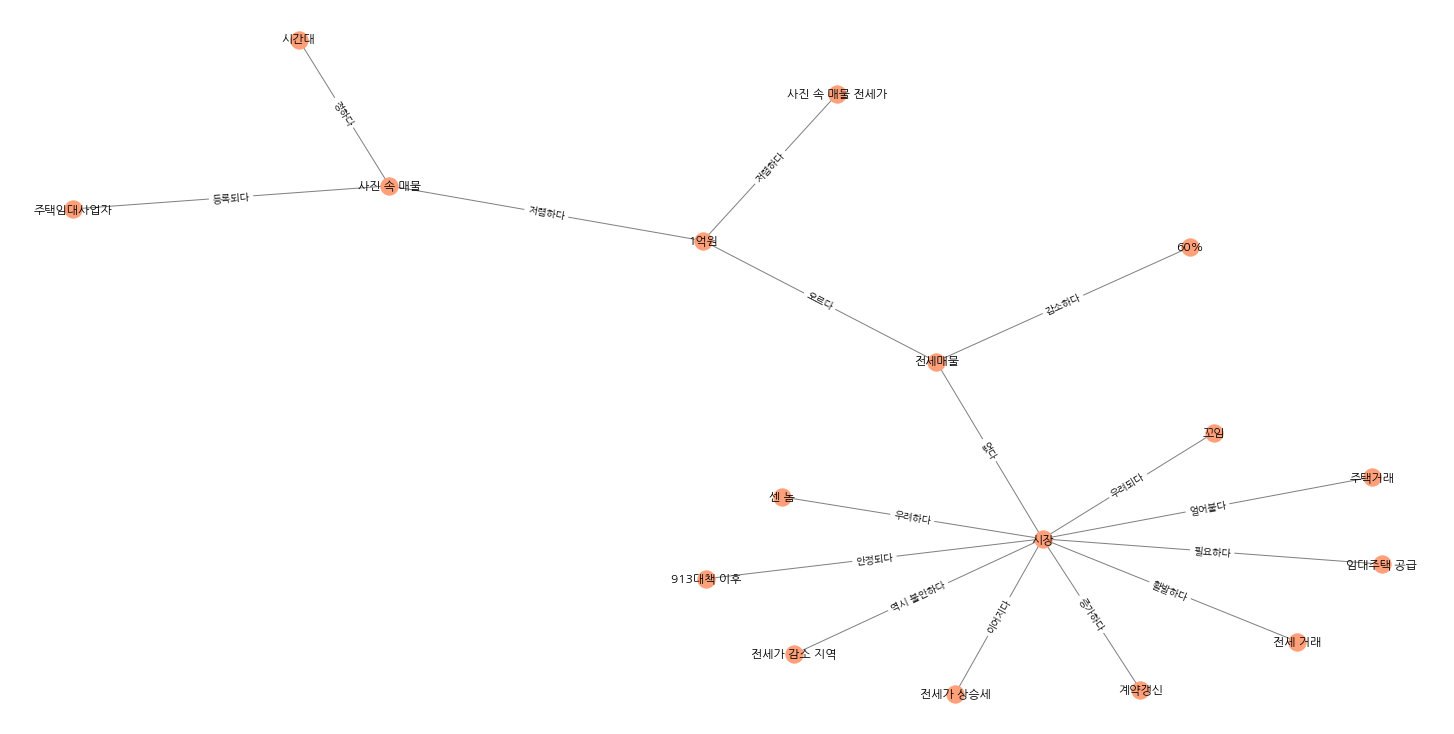

cluster 16


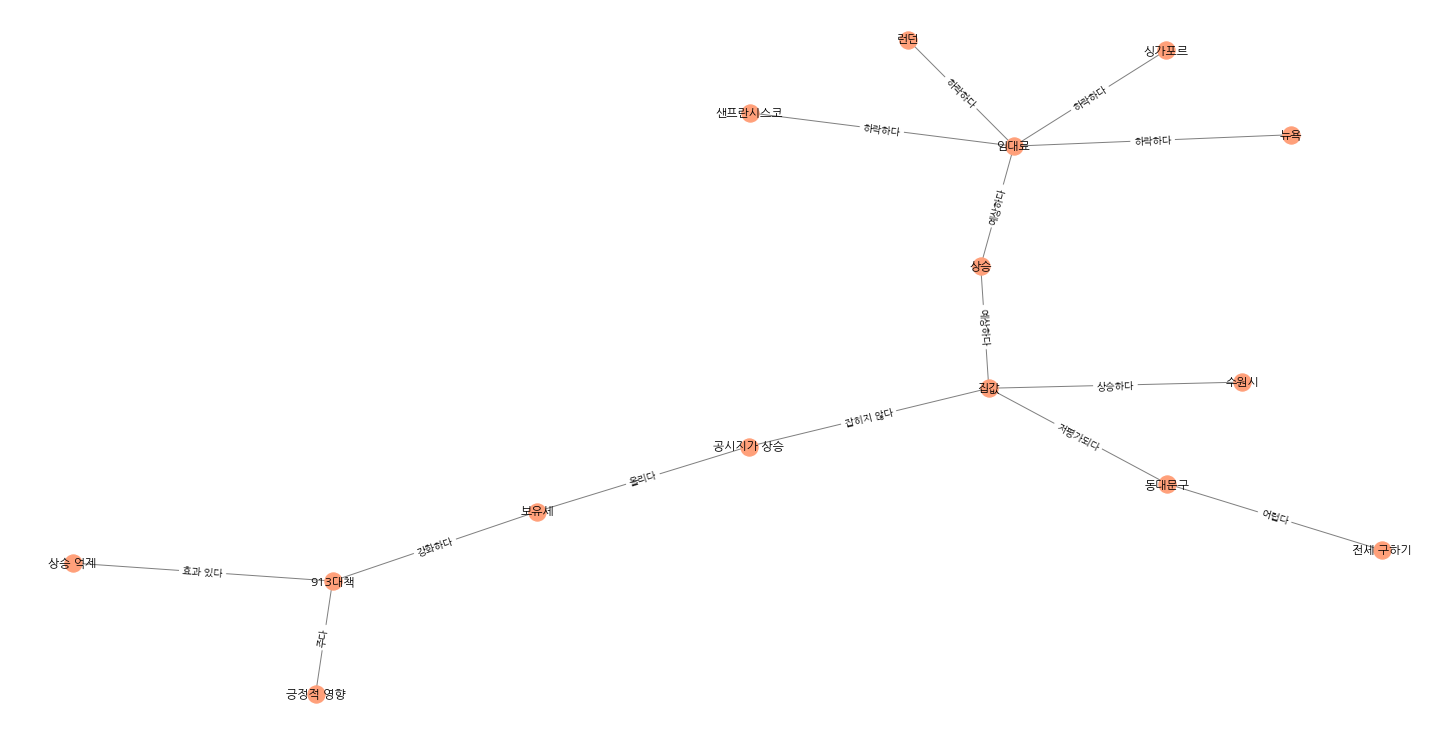

cluster 17


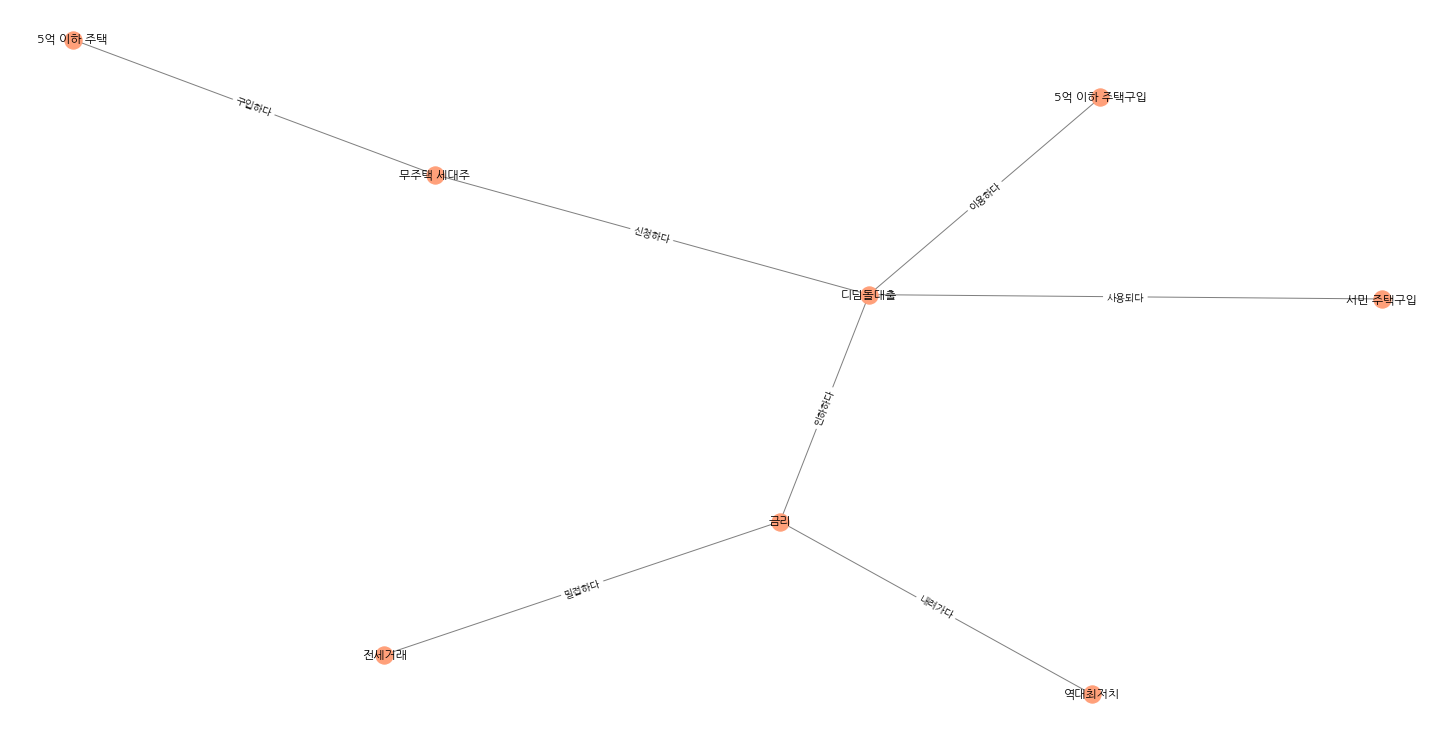

cluster 18


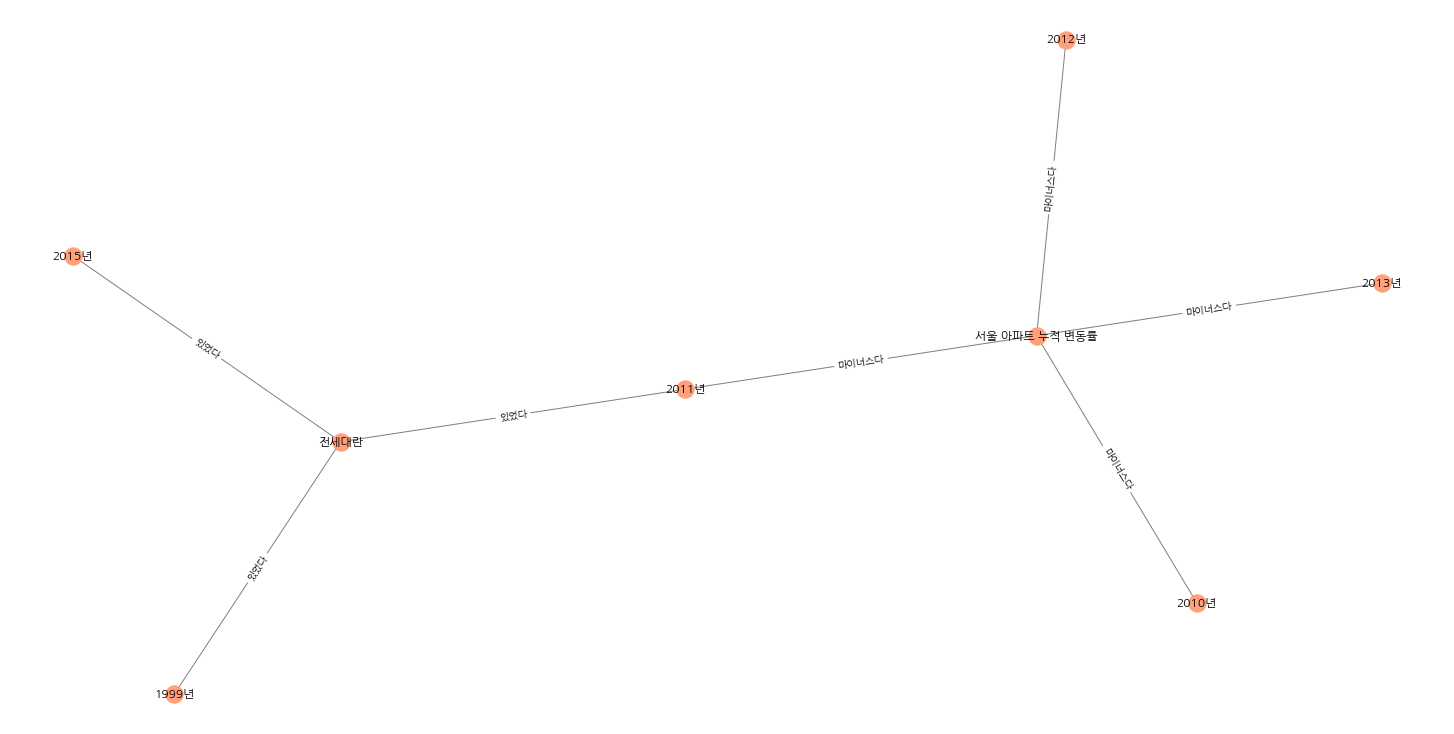

cluster 19


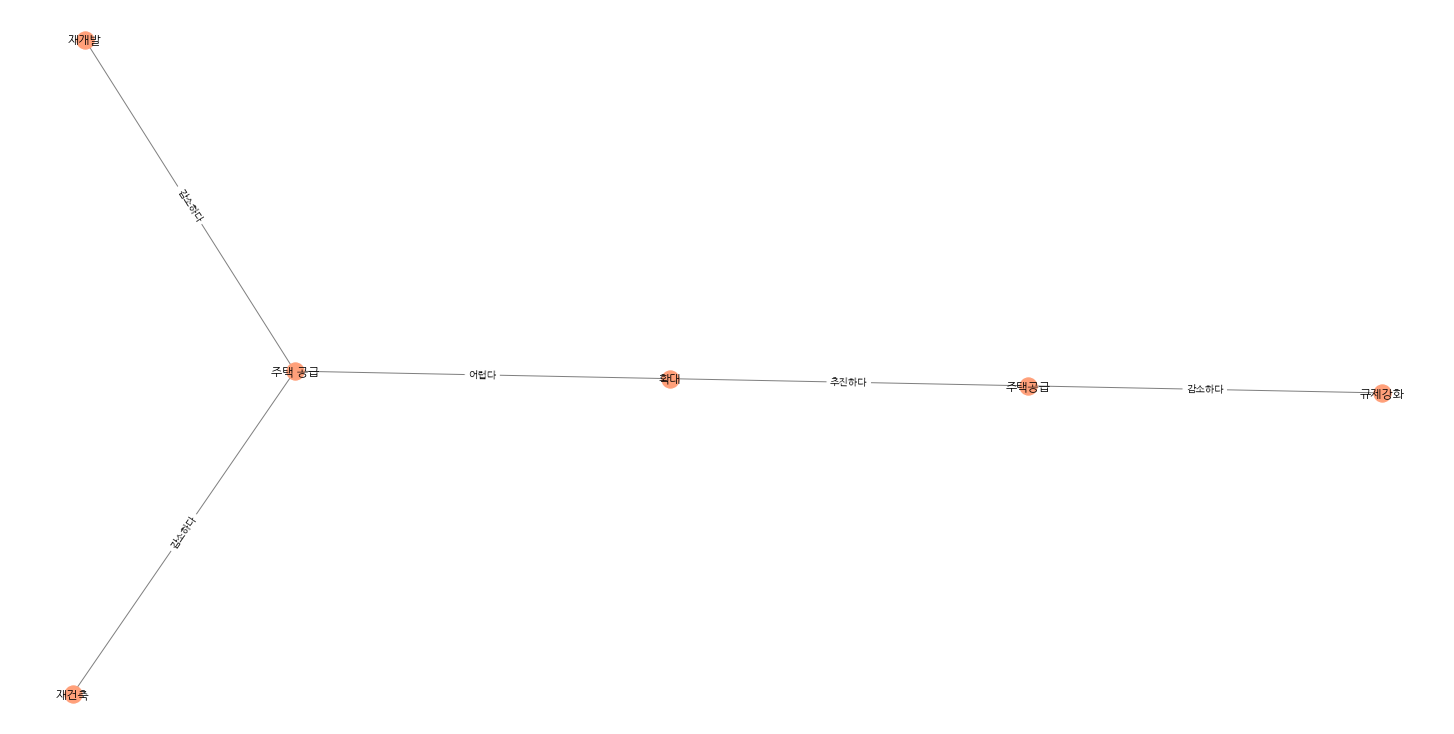

In [164]:
for i in range(len(clusters)):
    G = nx.Graph()
    G.add_nodes_from(nounlist[i])

    nodes = list(spolist[i].keys())
    edges = list(spolist[i].values())

    for j in range(len(nodes)):
        G.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])

    plt.figure(figsize=(20, 10))
    #레이아웃
    #planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
    #circular_layout, spring_layout, kamada_kawai_layout
    pos=nx.kamada_kawai_layout(G) 
    nx.draw(G, pos, with_labels = True, font_weigth = "bold", font_family=font_name, edge_color='gray', node_color='lightsalmon')

    labels = nx.get_edge_attributes(G,'verb')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_family=font_name)
    figname = './NPS_clusters_images/'+str(i)+'.png'
    plt.savefig(figname)
    print('cluster', i)
    plt.show()